In [1]:
import os
import io
import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow.keras.backend as K
from IPython import display

## Preprocess CelebA-dataset

In [2]:
dir_ = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
images = os.listdir("/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/")
len(images)

202599

In [3]:
ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images_paths = [os.path.join(dir_,x) for x in images]
DATASET_SIZE = len(images_paths)
train_size = int(0.7 * DATASET_SIZE)
#val_size = int(0.5 * DATASET_SIZE)
test_size = int(0.3 * DATASET_SIZE)

train_dataset = images_paths[:train_size]

#test_dataset = images_paths[train_size:train_size + test_size]
train_dataset = train_dataset[:5000]
print(len(train_dataset))

5000


In [4]:
def preprocess(paths,image_size):
    images = []
    for path in paths:
        img = Image.open(path).crop(crop_rect)
        img = np.array(img) # im2arr.shape: height x width x channel
        #img = cv2.imread(path)
        #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size,image_size))
        img = img.astype('float32')
        #img = img/255.0
        img = (img - 127.5) / 127.5
        images.append(img)
    return np.array(images)

    
def mini_batches_(X, image_size, batch_size=128):
    """
    function to produce minibatches for training
    :param X: input placeholder
    :param Y: mask placeholder
    :param batch_size: size of each batch
    :return:
    minibatches for training
    
    """
    images_batch = []
    train_length = len(X)
    num_batches = int(np.floor(train_length / batch_size))
    for i in tqdm(range(num_batches)):
        batch_x = X[i * batch_size: i * batch_size + batch_size]
        batch_x = preprocess(batch_x,image_size)
        images_batch.append(batch_x)
    return images_batch
#gan_dataset = mini_batches_(train_dataset, image_size = 32,batch_size=128)

## Visualize original Images

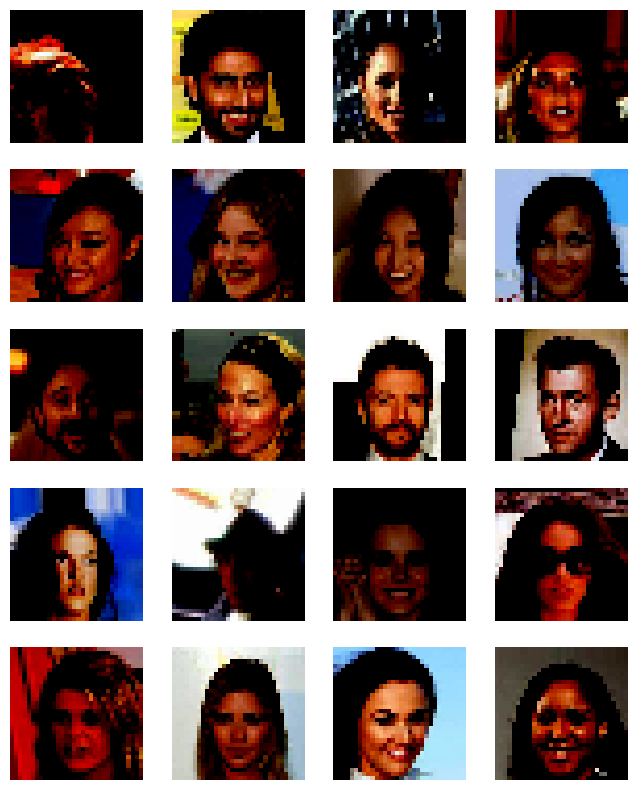

In [45]:
imgs = gan_dataset[1]

def plot_real_images(images,
                     n_to_show=20,
                     n_rows=5,
                     figsize=(8, 10)):
    
    fig = plt.figure(figsize=figsize)

    for i, x in enumerate(images[100:120]):
        ax = fig.add_subplot(n_rows, n_to_show // n_rows, i + 1)
        ax.axis('off')
        ax.imshow(x, interpolation='antialiased')
    plt.show()
    
plot_real_images(imgs)

## PGAN

In [5]:
#utils classes()
class PixelNormalization(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(PixelNormalization, self).__init__(**kwargs)
        
    def call(self, x):
        norm = x / (tf.math.sqrt(tf.reduce_mean(x ** 2, axis = -1, keepdims = True) + 1.0e-8) )
        return norm
    
class miniBatchStdev(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(miniBatchStdev,self).__init__(**kwargs)
    
    def call(self, x):
        sqaure_error = tf.square(x - tf.reduce_mean(x,axis = 0,keepdims = True))
        stddev_avg = tf.reduce_mean(tf.sqrt(tf.reduce_mean(sqaure_error, axis = 0, keepdims = True) + 1e-8),keepdims = True)
        shape = tf.shape(x)
        minibatch_tile = tf.tile(stddev_avg, (shape[0], shape[1], shape[2], 1))
        concat = tf.concat([x,minibatch_tile], axis = -1)
        return concat

In [6]:
class fadeInAlpha(tf.keras.layers.Add):#WeightedSum
    def __init__(self, alpha = 0.0,**kwargs):
        super(fadeInAlpha, self).__init__(**kwargs)
        self.alpha = K.variable(alpha, dtype='float32', name='alpha')
    def fad_in(self, inputs):
        output = (self.alpha * inputs[1]) + ((1.0 - self.alpha) * inputs[0])
        return output

In [7]:
class WeightScaling(tf.keras.layers.Layer):
    def __init__(self, in_channel, kernel_size, gain = 2,**kwargs):
        super(WeightScaling, self).__init__(**kwargs)
        self.gain = gain
        self.in_channel = in_channel
        self.kernel_size = kernel_size
        
    def call(self, inputs):
        wscale = np.sqrt(self.gain/ (self.in_channel * (self.kernel_size **2)))
        return inputs * wscale

class Bias(tf.keras.layers.Layer):
    def __init__(self):
        super(Bias, self).__init__()
    def call(self, inputs):
        init_ = tf.zeros_initializer()
        bias = tf.Variable(init_(shape = (inputs.get_shape().as_list()[-1],), dtype = 'float32'), trainable = True)
        return inputs + bias

In [8]:
def weighted_conv_layer(x,filters, kernel_size, gain = 2, activation = "LeakyReLU", pixel = True, average = False, stride = 1):
    in_channels = x.get_shape().as_list()[-1]
    init = RandomNormal(mean = 0., stddev = 1.)
    x = tf.keras.layers.Conv2D(filters,kernel_size, strides = (stride,stride), padding = "SAME", kernel_initializer = init, dtype = 'float32')(x)
    x = WeightScaling(in_channels,kernel_size, gain=gain)(x)
   # x = Bias()(x)
    if activation == "LeakyreLU":
        x = tf.keras.layers.LeakyReLU(0.2)(x)
    else:
        x = tf.keras.layers.Activation('tanh')(x)
    if pixel:
        x = PixelNormalization()(x)
    if average:
        x = tf.keras.layers.AveragePooling2D()(x)
    return x

filters = [128, 64, 64, 32, 16, 8]
#conv_block(x,filters, kernel_size, gain, activation = "LeakyReLU"):
def init_generator():
    #alpha = K.variable(0.0, dtype='float32', name='alpha')
    init = RandomNormal(mean = 0., stddev = 1.)
    noise = tf.keras.layers.Input(shape = (512,))
    x = PixelNormalization()(noise)
    #dense
    x = tf.keras.layers.Dense(filters[0] * 4 * 4, kernel_initializer = init)(x)
    x = tf.keras.layers.Reshape((4,4,filters[0]))(x)
    
    #add the 4x4 block
    x = weighted_conv_layer(x, filters[0], 4, gain = 2, activation = "LeakyReLU")
    #add the 3x3 block
    x = weighted_conv_layer(x, filters[0], 3, gain = 2, activation = "LeakyReLU")
    
    #add the toRGB 1x1 block
    x = weighted_conv_layer(x, 3, 1, gain = 1., activation = "tanh",pixel  = False)
    model = tf.keras.Model(noise, x)
    return model
model = init_generator()

In [9]:
def add_generator_block(init_model, i):
    #get the layer just before toRGB
    before_rgb_output = init_model.layers[-4].output
    
    #upsampling
    upsample = tf.keras.layers.UpSampling2D()(before_rgb_output)
    x = weighted_conv_layer(upsample, filters[i], 3, gain = 2, activation = "LeakyReLU")
    x = weighted_conv_layer(x, filters[i], 3, gain = 2, activation = "LeakyReLU")
    
    #new toRGB
    x = weighted_conv_layer(x, 3, 1, gain = 1., activation = "tanh", pixel  = False)
    
    #pass through previous toRGb block
    x1 = init_model.layers[-3](upsample)
    x1 = init_model.layers[-2](x1)
    x1 = init_model.layers[-1](x1)
    
    stable_gen = tf.keras.Model(init_model.input, x) #stable
    #fad-in the new layer
    x2 = fadeInAlpha()([x1,x])
    fad_in_gen = tf.keras.Model(init_model.input, x2) #fad-in
    return fad_in_gen,stable_gen

'for i in range(1,3):\n    print(i)\n    model,m2 = add_generator_block(model,i)\n    model = m2\nmodel.summary()'

In [10]:
#define discriminator
def init_discriminator():
    #alpha = K.variable(0.0, dtype='float32', name='alpha')
    init = RandomNormal(mean = 0., stddev = 1.)
    img_input = tf.keras.layers.Input(shape = (4,4,3))

    #add the from RGB block
    x = weighted_conv_layer(img_input, filters[0], 1, gain = 2, activation = "LeakyReLU",pixel = False)
    #minibatch
    x = miniBatchStdev()(x)
    
    #Add a 3x3 and 4x4 block
    x = weighted_conv_layer(x, filters[0], 3, gain = 2, activation = "LeakyReLU",pixel = False)
    x = weighted_conv_layer(x, filters[0], 4, gain = 2, activation = "LeakyReLU",pixel = False, stride = 4)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, kernel_initializer = init)(x)
    model = tf.keras.Model(img_input, x)
    return model


'model = init_discriminator()\nmodel.layers'

In [11]:
def add_dicriminator_block(init_model,o):
    input_shape = init_model.input.get_shape().as_list()
    input_shape = (input_shape[1]*2, input_shape[1]*2, input_shape[3])
    #input_shape
    new_input = tf.keras.layers.Input(shape = input_shape)
    
    #Fad-in block like the discriminator
    x2 = weighted_conv_layer(new_input, filters[o], 1, gain = 2, activation = "LeakyReLU")
    x2 = weighted_conv_layer(x2, filters[o], 3, gain = 2, activation = "LeakyReLU")
    x2 = weighted_conv_layer(x2, filters[o - 1], 3, gain = 2, activation = "LeakyReLU",average = True)
    
    #pass through previous FromRGb block
    x1 = tf.keras.layers.AveragePooling2D()(new_input)
    x1 = init_model.layers[1](x1)
    x1 = init_model.layers[2](x1)
    x1 = init_model.layers[3](x1)
    
    #fad_in layers
    x = fadeInAlpha()([x1,x2])
    
    #stable discriminator 
    for i in range(4, len(init_model.layers)):
        x2 = init_model.layers[i](x2)
    stable_discriminator = tf.keras.Model(new_input,x2)
    
    #Fad-in the layers
    for i in range(4, len(init_model.layers)):
        x = init_model.layers[i](x)
    discriminator = tf.keras.Model(new_input, x)
    return discriminator,stable_discriminator

'm1, m2 = add_dicriminator_block(model,2)\nm1 = m2\nm1, m2 = add_dicriminator_block(m1,3)\nm1 = m2\nm1, m2 = add_dicriminator_block(m1,4)\nm1 = m2\nm1, m2 = add_dicriminator_block(m1,5)\nm1 = m2\nm1, m2 = add_dicriminator_block(m1,6)\nm1 = m2\nm1.summary()'

In [12]:
#loss
def generator_loss(disc_fake_pred):
    return -tf.reduce_mean(disc_fake_pred)

def discriminator_loss(gen_fake, real_pred,gp):
    loss = tf.reduce_mean(gen_fake) - tf.reduce_mean(real_pred) + 10 * gp
    return loss

def gradient_penality(d_model,g_model,real_batch, noise, batch_size):
    epsilon = tf.random.uniform([batch_size,1,1,1],minval = 0, maxval = 1)
    with tf.GradientTape() as p_tape:
        gen_output = g_model(noise, training = True)
        gen_output_ = epsilon * real_batch + ((1 - epsilon) * gen_output)
        dis_gen_output_ = d_model(gen_output_,training = True)
    #compute gradients
    grads = p_tape.gradient(dis_gen_output_,gen_output_)
    ngrads = tf.sqrt(tf.reduce_sum(tf.square(grads),axis = [1,2,3]))
    grad_pen = tf.reduce_mean(tf.square(ngrads - 1))
    return grad_pen,gen_output

In [13]:
def update_alpha(models, i, n_steps_per_epoch):
    alpha = i/float(n_steps_per_epoch - 1)
    for model in models:
        for layer in model.layers:
            if isinstance(layer, fadeInAlpha):
                tf.compat.v1.assign(layer.alpha, alpha)

In [14]:
from IPython.display import FileLink
def train(g_model, d_model, train_dataset,
          image_size = 4,
          batch_size = 16,
          latin_dim = 512,
          critic_steps = 3, 
          epochs = 1000,
          network = "Stable", fadin = False):
    
    n_steps = int(len(train_dataset)/ batch_size) * epochs
    print("Creating Batches of Size {} with Image Size {} for {} Network.\n".format(batch_size, image_size, network))
    gan_dataset = mini_batches_(train_dataset, image_size,batch_size=batch_size)
    #print("Training for {} epochs.".format(n_steps))
    #n_steps = epochs #remove if doesn't work
    print("Training for {} epochs.".format(epochs))
    for epoch in range(epochs):
        if fadin: 
            update_alpha([g_model, d_model], epoch, n_steps)
        for real_batch in tqdm(gan_dataset):
            #train the critic
            for _ in range(critic_steps):
                noise = tf.random.uniform(shape = [batch_size,latin_dim])
                #train the discriminator
                with tf.GradientTape(persistent = True) as disc_tape:
                    #fake_images = g_model(noise, training = True)
                    #computer penality
                    grad_penality, fake_images = gradient_penality(d_model,g_model,real_batch,noise, batch_size)
                    #compute critic loss
                    critic_fake_output = d_model(fake_images, training = True)
                    critic_real_output = d_model(real_batch, training = True)
                    
                    cri_loss = discriminator_loss(critic_fake_output, critic_real_output, grad_penality )
                critic_grads = disc_tape.gradient(cri_loss, d_model.trainable_variables)
                critic_optimizer.apply_gradients(zip(critic_grads, d_model.trainable_variables))
            #noise samples  
            noise = tf.random.uniform(shape = [batch_size,latin_dim])
            with tf.GradientTape() as gen_tape:
                gen_output = g_model(noise, training = True)
                critic_gen_output = d_model(gen_output,training = True)
                gen_loss = generator_loss(critic_gen_output)
            gen_grads = gen_tape.gradient(gen_loss, g_model.trainable_variables)
            generator_optimizer.apply_gradients(zip(gen_grads, g_model.trainable_variables))
        print("Epoch {} / {} | Critic Loss {} | Generator Loss {} |".format(epoch+1,epochs,cri_loss,gen_loss)) 
        if epoch%50== 0 and network == "Intial":
            print("Saving weights of Initial network...\n")
            g_model.save_weights("/kaggle/working/Gan_weights/Initial/Generator_s{}_e{}.h5".format(str(image_size), str(epoch)))
            d_model.save_weights("/kaggle/working/Gan_weights/Initial/Critic_s{}_e{}.h5".format(str(image_size), str(epoch)))
           # print(FileLink(r'Gan_weights/Initial/Generator_s{}_e{}.h5'.format(str(image_size), str(epoch))))
           # print(FileLink(r'Gan_weights/Initial/Critic_s{}_e{}.h5'.format(str(image_size), str(epoch))))
            
        if epoch%50 == 0 and network == "Stable":
            print("Saving weights of Stable network...\n")
            g_model.save_weights("/kaggle/working/Gan_weights/Stable/Generator_s{}_e{}.h5".format(str(image_size), str(epoch)))
            d_model.save_weights("/kaggle/working/Gan_weights/Stable/Critic_s{}_e{}.h5".format(str(image_size), str(epoch)))
           # print(FileLink(r'Gan_weights/Stable/Generator_s{}_e{}.h5'.format(str(image_size), str(epoch))))
            #print(FileLink(r'Gan_weights/Stable/Critic_s{}_e{}.h5'.format(str(image_size), str(epoch))))
            
        if epoch % 5 ==0  :
            display.clear_output()
            print("Epoch {}/ {} | Critic Loss {} | Generator Loss {} |".format(epoch+1,n_steps,cri_loss,gen_loss))
            outputs = g_model(tf.random.uniform([20, latin_dim]), training=False)
            plot_real_images(outputs,
                     n_to_show=20,
                     n_rows=5,
                     figsize=(8, 10))

In [15]:
def plot_real_images(images,
                     n_to_show=20,
                     n_rows=5,
                     figsize=(8, 10)):
    
    fig = plt.figure(figsize=figsize)

    for i, x in enumerate(images):
        ax = fig.add_subplot(n_rows, n_to_show // n_rows, i + 1)
        ax.axis('off')
        ax.imshow(x, interpolation='antialiased')
    plt.show()

## Train 4x4 images

In [ ]:
#Loading weights 8x8
#define g and c models
g_model = init_generator()
d_model = init_discriminator()

#batch_sizes  4,   8, 16, 32, 64, 128
batch_size = [16, 16, 8, 8, 4, 4]
#n_epochs = [5, 8, 8, 10,10 , 10]
EPOCHS = 50
gen_learning_rate = 0.00005
critic_learning_rate = 0.00005
    
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)   
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)

train(g_model, d_model, train_dataset, image_size = 4, batch_size = 64, epochs = 100, network = "Intial")

In [ ]:
g_model.save_weights("//kaggle/input/trained-weightsv3/Generator_initial_s4.h5")
d_model.save_weights("/kaggle/input/trained-weightsv3/Critic_initial_s4.h5")

In [16]:
EPOCHS = 50
gen_learning_rate = 0.00005
critic_learning_rate = 0.00005
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)   
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)

In [17]:
g_model = init_generator()
d_model = init_discriminator()

g_model.load_weights("/kaggle/input/gan-weightsv2/Generator_initial_s4.h5")
d_model.load_weights("/kaggle/input/gan-weightsv2/Critic_initial_s4.h5")

In [ ]:
from IPython.display import FileLink
FileLink(r'Generator_initial_s4.h5')

# Train 8x8 image size

In [19]:
#add blocks
g_model, stable_gen = add_generator_block(g_model, 1)
d_model, stable_disc = add_dicriminator_block(d_model, 1)

train(g_model, d_model, train_dataset, image_size = 4 *(2**1), batch_size = 64, epochs = 100 , network = "Fad-In", fadin = True)
g_model.load_weights("/kaggle/input/gan-weightsv2/Generator_fadin_s8.h5")
d_model.load_weights("/kaggle/input/gan-weightsv2/Critic_fadin_s8.h5")

g_model = stable_gen
d_model = stable_disc

#train(g_model, d_model, train_dataset, image_size = 4 *(2**1), batch_size =  64, epochs = 100 ,network = "Stable", fadin = False)
g_model.load_weights("/kaggle/input/gan-weightsv2/Generator_stable_s8.h5")
d_model.load_weights("/kaggle/input/gan-weightsv2/Critic_stable_s8.h5")

## Train 16x16 Images

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)   
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)

#add blocks
g_model, stable_gen = add_generator_block(g_model, 2)
d_model, stable_disc = add_dicriminator_block(d_model, 2)

train(g_model, d_model, train_dataset, image_size = 4 *(2**2), batch_size = 64, epochs = 100 , network = "Fad-In", fadin = True)
g_model.save_weights("/kaggle/working/Generator_fadin_s16.h5")
d_model.save_weights("/kaggle/working/Critic_fadin_s16.h5")

g_model = stable_gen
d_model = stable_disc

train(g_model, d_model, train_dataset, image_size = 4 *(2**2), batch_size =  64, epochs = 100 ,network = "Stable", fadin = False)
g_model.save_weights("/kaggle/working/Generator_stable_s16.h5")
d_model.save_weights("/kaggle/working/Critic_stable_s16.h5")

## Train 32x32 Image size

Epoch 36/ 4680 | Critic Loss -5.991509437561035 | Generator Loss 310.5487060546875 |


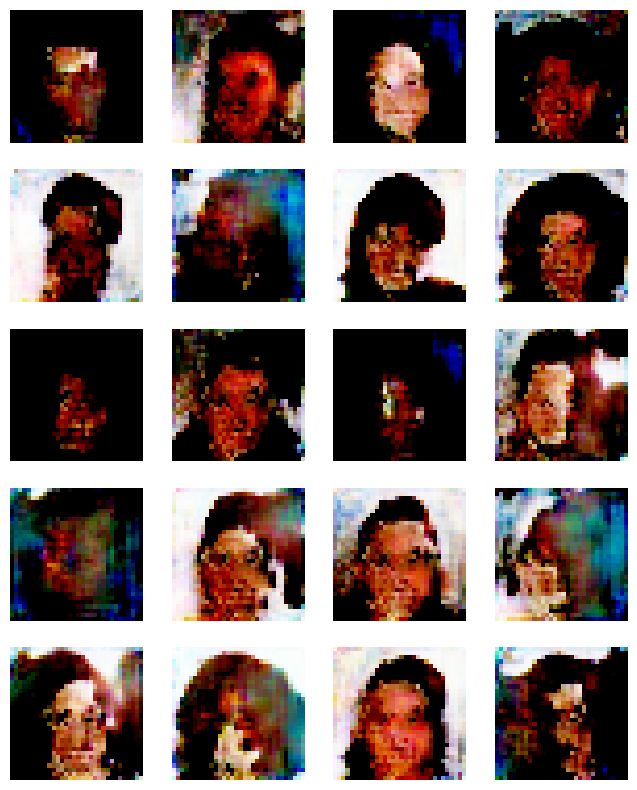

100%|██████████| 78/78 [01:47<00:00,  1.37s/it]


Epoch 37 / 60 | Critic Loss -14.07715129852295 | Generator Loss 310.79437255859375 |


100%|██████████| 78/78 [01:44<00:00,  1.34s/it]


Epoch 38 / 60 | Critic Loss -15.547740936279297 | Generator Loss 305.9993896484375 |


 23%|██▎       | 18/78 [00:23<01:25,  1.42s/it]

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)   
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)

#add blocks
g_model, stable_gen = add_generator_block(g_model, 3)
d_model, stable_disc = add_dicriminator_block(d_model, 3)

train(g_model, d_model, train_dataset, image_size = 4 *(2**3), batch_size = 64, epochs = 60 , network = "Fad-In", fadin = True)
g_model.save_weights("/kaggle/working/Generator_fadin_s32.h5")
d_model.save_weights("/kaggle/working/Critic_fadin_s32.h5")

g_model = stable_gen
d_model = stable_disc

train(g_model, d_model, train_dataset, image_size = 4 *(2**3), batch_size =  64, epochs = 60 ,network = "Stable", fadin = False)
g_model.save_weights("/kaggle/working/Generator_stable_s32.h5")
d_model.save_weights("/kaggle/working/Critic_stable_s32.h5")

## Train 64x64 Images

Epoch 116/ 9360 | Critic Loss -3.1060917377471924 | Generator Loss 469.8890380859375 |


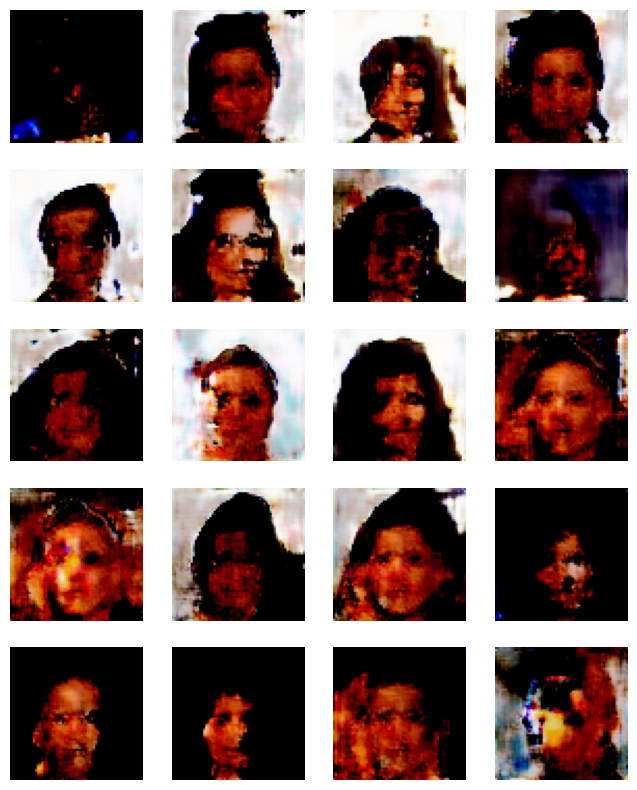

100%|██████████| 78/78 [02:05<00:00,  1.61s/it]


Epoch 117 / 120 | Critic Loss -4.747125625610352 | Generator Loss 478.7283935546875 |


100%|██████████| 78/78 [02:04<00:00,  1.59s/it]


Epoch 118 / 120 | Critic Loss -5.904275894165039 | Generator Loss 482.78253173828125 |


100%|██████████| 78/78 [02:04<00:00,  1.60s/it]


Epoch 119 / 120 | Critic Loss -35.352027893066406 | Generator Loss 441.154052734375 |


100%|██████████| 78/78 [02:04<00:00,  1.59s/it]

Epoch 120 / 120 | Critic Loss 0.686090886592865 | Generator Loss 477.3621826171875 |


In [29]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)   
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)

#add blocks
g_model, stable_gen = add_generator_block(g_model, 4)
d_model, stable_disc = add_dicriminator_block(d_model, 4)

train(g_model, d_model, train_dataset, image_size = 4 *(2**4), batch_size = 64, epochs = 60 , network = "Fad-In", fadin = True)
g_model.load_weights("/kaggle/input/gan-weightsv2/Generator_fadin_s64.h5")
d_model.load_weights("/kaggle/input/gan-weightsv2/Critic_fadin_s64.h5")

g_model = stable_gen
d_model = stable_disc

train(g_model, d_model, train_dataset, image_size = 4 *(2**4), batch_size =  64, epochs = 120 ,network = "Stable", fadin = False)
g_model.save_weights("/kaggle/working/Generator_stable_s64.h5")
d_model.save_weights("/kaggle/working/Critic_stable_s64.h5")

## Visualize 64x64 Images 

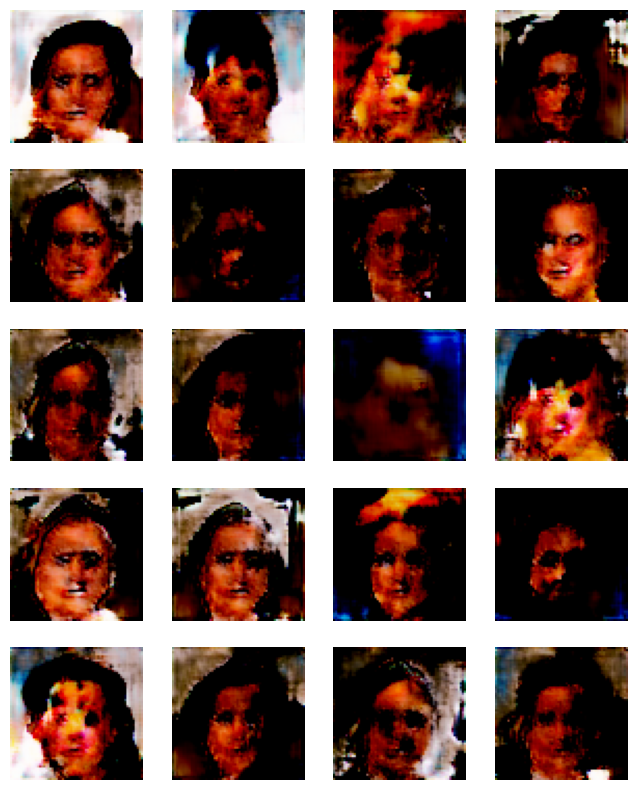

In [25]:
outputs = g_model(tf.random.uniform([20, 512]), training=False)
plot_real_images(outputs,
                     n_to_show=20,
                     n_rows=5,
                     figsize=(8, 10))

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)   
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)

#add blocks
g_model, stable_gen = add_generator_block(g_model, 5)
d_model, stable_disc = add_dicriminator_block(d_model, 5)

train(g_model, d_model, train_dataset, image_size = 4 *(2**5), batch_size = 64, epochs = 60 , network = "Fad-In", fadin = True)
g_model.save_weights("/kaggle/working/Generator_fadin_s128.h5")
d_model.save_weights("/kaggle/working/Critic_fadin_s128.h5")

g_model = stable_gen
d_model = stable_disc

train(g_model, d_model, train_dataset, image_size = 4 *(2**5), batch_size =  64, epochs = 60 ,network = "Stable", fadin = False)
g_model.save_weights("/kaggle/working/Generator_stable_s128.h5")
d_model.save_weights("/kaggle/working/Critic_stable_s128.h5")